In [2]:
# Preprocessing module
## Loads COCO images and annotations and perform necessary preprocessing.
## Since the individual datasets are <20GB (smaller after filtering & resizing),
## we opt to simply store everything in an ndarray. If more data is present
## we should probably use the `tf.data` API.

import numpy as np
from warnings import warn
from os import path
from skimage import img_as_float
from skimage.io import imread
from skimage.transform import resize
from pycocotools.coco import COCO
from config import NUM_KEYPOINTS, image_shape, sigma
import matplotlib.pyplot as pyplot

In [16]:
def update_confidence_map(img_shape, Y, annos, sigma, image_path):
    """
    Updates the w' x h' x NUM_KEYPOINTS confidence maps Y using one person's
    keypoints data.
    """
    Y_tmp = np.zeros((img_shape[0], img_shape[1], NUM_KEYPOINTS))
   
   
    for anno in annos:
        keypoints = anno["keypoints"]
        if len(keypoints) != 3 * NUM_KEYPOINTS:
            warn(f"Keypoints data for {image_path} is corrupted.")
            continue
        for k in range(NUM_KEYPOINTS):
            y, x, visibility = keypoints[3*k], keypoints[3*k+1], keypoints[3*k+2]
            if visibility == 2: # labeled and visible
                # Scale the coordinates
                # x /= scale[0]
                # y /= scale[1]
                # Calculate using a Gaussian kernel and take max
                # TODO: vectorize this part
                for i in range(img_shape[0]):
                    for j in range(img_shape[1]):
                        Y_tmp[i,j,k] = max(Y_tmp[i,j,k], np.exp(-((i - x)**2 + (j - y)**2) / sigma**2))
    Y[:,:,:] = resize(Y_tmp, Y.shape, mode='reflect', anti_aliasing=True)   
                    

def load_data(data_dir, data_type, image_shape=image_shape, sigma=sigma, num_input=None, verbose=False, 
             image_ids = None):
    """
    Load raw data from disk and preprocess into feature and label tensors.

    - data_dir: path to COCO dataset

    - data_type: 'train2014', 'val2014', 'test2014' or 'test2015'

    - image_shape: standardized shape to resize raw images into. Default: (224,224).

    - sigma: width of the Gaussian kernel used in the construction of the ground truth
      confidence map. Default: 1.0.

    - num_input: how many inputs to use, or all if set to None. Default: None.
    """

    # Load metadata
    image_dir = path.join(data_dir, "images", data_type)
    anno_path = path.join(data_dir, "annotations", f"person_keypoints_{data_type}.json")
    coco = COCO(anno_path)
    if image_ids == None:
        image_ids = coco.getImgIds(
            catIds=coco.getCatIds(catNms=['person'])
        ) # only load person images
        image_ids = np.random.permutation(image_ids)
        if num_input != None:
            image_ids = image_ids[:num_input]
    print(image_ids)
    images = coco.loadImgs(image_ids)

    # Allocate feature and label tensor
    ## For the confidence map, here we hard-code its shape as 1/8 of the input shape
    ## (as a result of three pooling layers in Vgg19).
    if image_shape[0] % 8 != 0 or image_shape[1] % 8 != 0:
        warn("Input shape not divisible by 8.")
    confmap_shape = (image_shape[0]//8, image_shape[1]//8)
    X = np.ndarray((len(images), *image_shape, 3))
    Y = np.zeros((len(images), *confmap_shape, NUM_KEYPOINTS)) # one confidence map for each keypoint

    # Build the tensors
    for i, img_data in enumerate(images):
        # Build X (feature; scaled and resized input image)
        img_path = path.join(image_dir, img_data['file_name'])
        verbose and print("Processing ", img_path)
        img = img_as_float(imread(img_path)) # scale pixel value to [0,1]
        if len(img.shape) == 2:
            # Handle black and white images
            img = np.tile(np.reshape(img, (*img.shape, 1)), 3)
        X[i,:,:,:] = resize(img, image_shape, mode='reflect', anti_aliasing=True)

        # Compute the scale between the raw image and the confidence maps.
        # Used to convert keypoint coordinates in the raw image to coordinates
        # in the confidence maps.
        scale = (img.shape[0] / confmap_shape[0], img.shape[1] / confmap_shape[1])

        # Build Y (label; ground truth confidence maps)
        annos = coco.loadAnns(coco.getAnnIds(imgIds=img_data['id']))
        update_confidence_map(img.shape, Y[i,:,:,:], annos, sigma, img_path)

    return X, Y

In [19]:
X, Y = load_data("../dataset/COCO", 'train2014', sigma=8.0, num_input=10, 
                 image_ids = [159592, 332824, 517101, 203926,   5699, 542809, 522938, 396762, 417315, 305385, 
                              499094,  81809, 332203, 282428,  77504])

loading annotations into memory...
Done (t=6.34s)
creating index...
index created!
[159592, 332824, 517101, 203926, 5699, 542809, 522938, 396762, 417315, 305385, 499094, 81809, 332203, 282428, 77504]


In [20]:
np.save("X_train_resize1", X)
np.save("Y_train_resize1", Y)

0.403850228727739
105.95332715142455


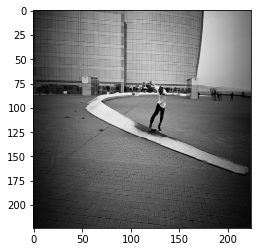

In [10]:
print(np.amax(Y))
print(np.sum(Y))
pyplot.imshow(X[0])

In [17]:
b.shape


(4, 5, 3)

In [19]:
c = b.transpose((1, 2, 0))

In [20]:
c.shape

(5, 3, 4)